In [1]:
import scanpy as sc
import plotnine as p9

import liana as li
import decoupler as dc # needed for pathway analysis

import numpy as np
import pandas as pd

In [2]:
import muon as mu
import mofax as mofa

TODO:
- Functions to extract MOFA values assigned to `obsm` & `varm` (so that we don't save the model), and plot them

## Preprocess

In [3]:
# TODO Utility function for this

# load data as from CCC chapter
adata = sc.read(
    "kang_counts_25k.h5ad", backup_url="https://figshare.com/ndownloader/files/34464122"
    )

# Store the counts for later use
adata.layers["counts"] = adata.X.copy()

# Rename label to condition, replicate to patient
adata.obs = adata.obs.rename({"label": "condition", "replicate": "patient"}, axis=1)

# assign sample
adata.obs["sample"] = (
    adata.obs["condition"].astype("str") + "&" + adata.obs["patient"].str.slice(8, 13)
    )

In [4]:
# set cell_types abbreviations (recommended given MOFA appends names and all)
abbreviations = {'CD4 T cells':'CD4T', 'B cells':'B', 'NK cells':'NK', 'CD8 T cells':'CD8T', 'FCGR3A+ Monocytes':'FGR3', 'CD14+ Monocytes':'CD14', 'Dendritic cells':'DCs', 'Megakaryocytes':'Mega'}
adata.obs["cell_abbr"] = adata.obs["cell_type"].replace(abbreviations)

In [5]:
sample_key = 'sample'
groupby = 'cell_abbr'

In [6]:
adata

AnnData object with n_obs × n_vars = 24673 × 15706
    obs: 'nCount_RNA', 'nFeature_RNA', 'tsne1', 'tsne2', 'condition', 'cluster', 'cell_type', 'patient', 'nCount_SCT', 'nFeature_SCT', 'integrated_snn_res.0.4', 'seurat_clusters', 'sample', 'cell_abbr'
    var: 'name'
    obsm: 'X_pca', 'X_umap'
    layers: 'counts'

## MOFAcell

In [7]:
from liana.multi import adata_to_views, lrs_to_views, get_variable_loadings, get_factor_scores

In [8]:
mdata = adata_to_views(adata,
                       groupby=groupby,
                       sample_key=sample_key,
                       obs_keys=['condition', 'patient'],
                       min_prop=0.05, # min nnz values (filter features)
                       min_smpls=3, # min samples per view (filter features)
                       min_cells=25, # min cells per view (filter samples)
                       min_counts=100, # min counts per view (filter samples)
                       mode='sum', # mode of aggregation
                       verbose=True
                       )

100%|██████████| 8/8 [00:02<00:00,  2.74it/s]


In [9]:
mdata

MuData object with n_obs × n_vars = 16 × 23072
  obs:	'condition', 'patient'
  7 modalities
    CD14:	16 x 3308
    CD4T:	16 x 2719
    DCs:	10 x 4781
    NK:	14 x 2791
    CD8T:	11 x 2523
    B:	16 x 3135
    FGR3:	11 x 3815

#### Normalize and get HVGs for each view

In [10]:
for view in mdata.mod.keys():
    sc.pp.normalize_total(mdata.mod[view], target_sum=1e4)
    sc.pp.log1p(mdata.mod[view])
    sc.pp.highly_variable_genes(mdata.mod[view], flavor='cell_ranger')

In [11]:
# check how a view looks
mdata.mod['B']

AnnData object with n_obs × n_vars = 16 × 3135
    var: 'highly_variable', 'means', 'dispersions', 'dispersions_norm'
    uns: 'log1p', 'hvg'

Run MOFA

In [12]:
mu.tl.mofa(mdata,
           use_obs='union',
           convergence_mode='medium',
           verbose=True,
           n_factors=5,
           outfile='models/mofacell.h5ad'
           )


        #########################################################
        ###           __  __  ____  ______                    ### 
        ###          |  \/  |/ __ \|  ____/\    _             ### 
        ###          | \  / | |  | | |__ /  \ _| |_           ### 
        ###          | |\/| | |  | |  __/ /\ \_   _|          ###
        ###          | |  | | |__| | | / ____ \|_|            ###
        ###          |_|  |_|\____/|_|/_/    \_\              ###
        ###                                                   ### 
        ######################################################### 
       
 
        
Loaded view='CD14' group='group1' with N=16 samples and D=3308 features...
Loaded view='CD4T' group='group1' with N=16 samples and D=2719 features...
Loaded view='DCs' group='group1' with N=16 samples and D=4781 features...
Loaded view='NK' group='group1' with N=16 samples and D=2791 features...
Loaded view='CD8T' group='group1' with N=16 samples and D=2523 features...
Loaded vi

In [14]:
factor1_loadings =  get_variable_loadings(mdata, 0, view_separator=':')
factor1_loadings

,loadings,view,variable
4435,3.141628e+00,CD4T,LAG3
4433,3.115246e+00,CD4T,KXD1
3827,3.106466e+00,CD4T,CPNE1
6130,3.098568e+00,DCs,AIFM2
5612,3.089719e+00,CD4T,SYTL3
...,...,...,...
17570,4.048312e-06,B,MED19
13681,3.562249e-06,CD8T,APMAP
16400,-2.434615e-06,B,BZW2
10519,-8.887350e-07,DCs,UBR5


In [15]:
?get_variable_loadings

Signature:
get_variable_loadings(
    mdata,
    idx,
    varm_key='LFs',
    view_separator=None,
    variable_separator=None,
    pair_separator=None,
    var_names=['ligand_complex', 'receptor_complex'],
    pair_names=['source', 'target'],
    drop_columns=True,
)
Docstring:
A helper function to extract variable loadings from a MuData object.

Parameters
----------

mdata: :class:`~mudata.MuData`
    MuData object
idx: int
    Index of the variable to extract. Pass index 0 to extract the first Factor.
varm_key: str
    Key to use when extracting variable loadings from `mdata.varm`
view_separator: str
    Separator to use when splitting view:variable names into view and variable
variable_separator: str
    Separator to use when splitting variable names into `var_names` ('ligand_complex' and 'receptor_complex' by default)
pair_separator: str
    Separator to use when splitting view names into `pair_names` ('source' and 'target' by default)
drop_columns: bool
    If True, drop the `vi

In [16]:
top_genes = factor1_loadings['variable'].head(25)

In [17]:
top_genes

4435         LAG3
4433         KXD1
3827        CPNE1
6130        AIFM2
5612        SYTL3
1263        HSPA8
4434        LACTB
1213     HLA-DRB5
21369      NFKBID
10150         TFG
10146       TEX30
10186      TIMM8B
4417        KIF2A
21371      NFKBIZ
1209     HLA-DQA1
4495         LSM4
10148       TFDP1
7471         FEZ2
4463       LGALS3
21412        NRD1
7475     FGFR1OP2
1211      HLA-DRA
7473     FGD5-AS1
10442       TUBB6
4863        PARP8
Name: variable, dtype: object

In [21]:
top_loadings = factor1_loadings[factor1_loadings['variable'].isin(top_genes)]

In [19]:
import plotnine as p9

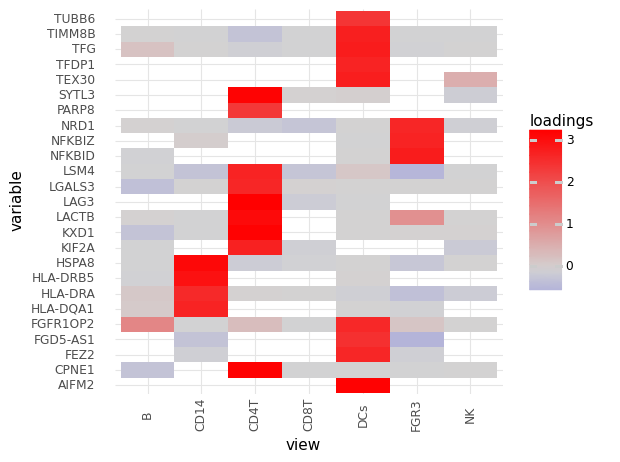

<ggplot: (8785539807202)>

In [23]:
# dotplot of variable, view, loadings
(p9.ggplot(top_loadings) + 
 p9.aes(x='view', y='variable', fill='loadings') + 
 p9.geom_tile() +
 p9.scale_fill_gradient2(low='blue', mid='lightgray', high='red') + 
 p9.theme_minimal() +
 p9.theme(axis_text_x=p9.element_text(angle=90, hjust=0.5, vjust=0.5), figure_size=(5, 5))
 )

In [25]:
factor_scores = get_factor_scores(mdata, obsm_key='X_mofa')

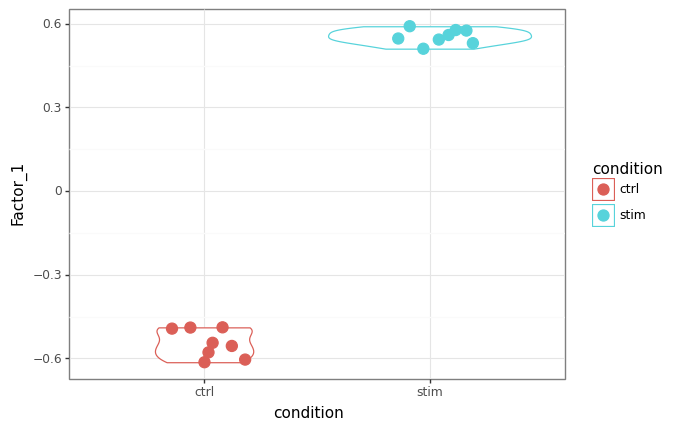

<ggplot: (8785539878919)>

In [26]:
# scatterplot
(p9.ggplot(factor_scores) +
 p9.aes(x='condition', colour='condition', y='Factor_1') +
 p9.geom_violin() +
 p9.geom_jitter(size=4, width=0.2) +
 p9.theme_bw()
 )

In [45]:
mdata.obsm['X_mofa'].shape

(16, 5)

R-squared per view

In [13]:
model = mofa.mofa_model("models/mofacell.h5ad")
model

MOFA+ model: mofacell.h5ad
Samples (cells): 16
Features: 23072
Groups: group1 (16)
Views: B (3135), CD14 (3308), CD4T (2719), CD8T (2523), DCs (4781), FGR3 (3815), NK (2791)
Factors: 5
Expectations: W, Z

In [ ]:
mofa.plot_r2(model, x='View')

Genes with high loadings

In [ ]:
# Check loadings for CD14+ Monocytes
mofa.plot_weights(model, views=['CD14'], factors="Factor1", label_size=10)

In [ ]:
model.close()

In [ ]:
sc.pp.neighbors(mdata, use_rep="X_mofa")
sc.tl.umap(mdata, random_state=1)
sc.pl.umap(mdata, frameon=False, color=['condition', 'patient'])

In [ ]:
mdata.varm['LFs'].shape

In [ ]:
mdata

### MOFAtalk

In [ ]:
sc.pp.normalize_total(adata)
sc.pp.log1p(adata)

In [ ]:
li.mt.rank_aggregate.by_sample(
    adata,
    groupby=groupby,
    sample_key=sample_key, # sample key by which we which to loop
    use_raw=False,
    verbose=True, # use 'full' to show all information
    n_perms=100, # reduce permutations for speed
    return_all_lrs=False, # important for how missing values are handled
    )

### dataframe_to_views

In [ ]:
mdata = lrs_to_views(adata,
                     score_key='magnitude_rank',
                     obs_keys=['patient', 'condition'],
                     verbose=True
                     )

In [ ]:
mu.tl.mofa(mdata, 
           use_obs='union',
           convergence_mode='medium',
           outfile='models/talk.h5ad',
           n_factors=5,
           save_metadata=True)

In [ ]:
model = mofa.mofa_model('models/talk.h5ad')

In [ ]:
model.get_r2()

### Extract MOFA values

Both functions should work with mdata getting passed

In [ ]:
factor1_loadings = get_variable_loadings(mdata, 0, view_separator=':', variable_separator='^', pair_separator='&')

In [ ]:
factor1_loadings.drop(columns=['view:variable', 'view', 'variable'], inplace=True)

In [ ]:
factor1_loadings['size'] = 5

In [ ]:
my_plot = li.pl.dotplot(liana_res = factor1_loadings,
              size='size',
              colour='loadings', 
              orderby='loadings',
              top_n=20,
              source_labels=['NK', 'B', 'CD4T', 'CD8T'],
              orderby_ascending=False,
              size_range=(0.1, 6),
              figure_size=(8, 8)
              )

In [ ]:
# change colour, with mid as white
my_plot + p9.scale_color_gradient2(low='blue', mid='lightgray', high='red')

Get Factor Scores

In [ ]:
factor_scores = get_factor_scores(mdata, obsm_key='X_mofa')

In [ ]:
# scatterplot
(p9.ggplot(factor_scores) +
 p9.aes(x='condition', colour='condition', y='Factor_1') +
 p9.geom_violin() +
 p9.geom_jitter(size=4, width=0.2) +
 p9.theme_bw()
 )